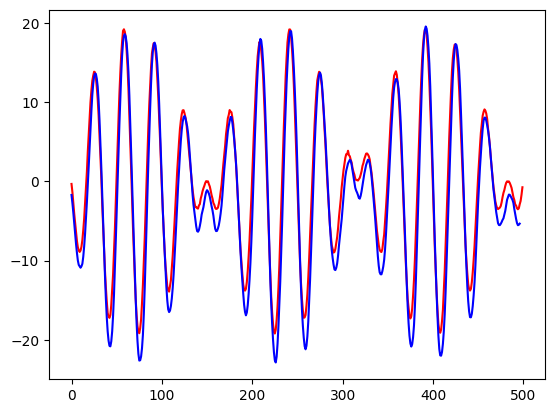

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_name):
    """Reads the file and extracts the data columns"""
    # time, measure; input, record
    data = np.loadtxt(file_name)
    time_data = data[:, 0]
    input_data = data[:, 1]
    return time_data, input_data

def plot_input_data(input_data):
    """Plots the input data"""
    plt.figure()
    plt.plot(input_data, linewidth=2, color='red', label='Input Data')
    plt.title('Input Data')
    plt.ylabel('Voltage (V)')
    plt.legend(loc='lower right')
    plt.show()

def plot_measure_data(measure_data):
    """Plots the measured data"""
    plt.figure()
    plt.style.use('seaborn-whitegrid')
    plt.plot(measure_data, linewidth=2, color='blue', label='Measured Data')
    plt.title('Measured Data')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (V)')
    plt.legend(loc='lower right')
    plt.show()

# Define the file name containing Chinese characters
file_name = './data/Sine30HzAM3_30mV_1mVNoise.txt'

time_delay = 3 # ms

# Read the data
time_data, input_data = read_data(file_name)

start_num = 1005
measure_num = start_num + 500

cropped_time_data = time_data[(start_num+time_delay):(measure_num+time_delay)]
cropped_input_data = input_data[start_num:measure_num]
b_input = cropped_input_data * 1000 # V --> mV --> pT , mV
y_measure = cropped_time_data * 1000 # V --> mV
y_measure_current = time_data[start_num:measure_num] * 1000

# Plot the input data
# plot_input_data(cropped_input_data[:100])
# plot_input_data(cropped_time_data[:100])
# Plot the measured data
#plot_measure_data(cropped_time_data)
plt.plot(1.3*b_input, color='red')
plt.plot(y_measure_current[(time_delay):(500+time_delay)], color='blue')

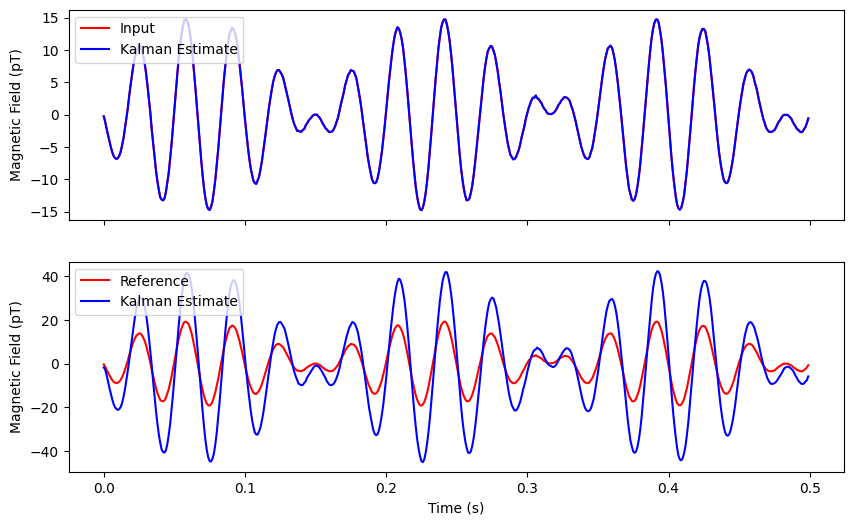

In [19]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import numpy as np

# Define constants
Z_REF_SCALE = 1.3
Q1 = 0
Q2 = 0.000118147
#Q2 = 11.2845*1e-5
GR_PSN = 5.657*1e-3
#GR_PSN = 0.0286
DT = 1/1000

# Calculate reference
z_ref = Z_REF_SCALE * b_input

# Create Kalman filter
tracker = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
tracker.F = np.array([[0, 0], [9.598*1e-2, 0]])
tracker.Q = np.array([[Q1**2, 0], [0, Q2**2]])
tracker.B = np.array([[1], [0]])
tracker.H = np.array([[0, 1e2]])
tracker.R = np.array([[GR_PSN**2]])
tracker.x = np.array([[0], [0]])
tracker.P = np.eye(2) * 1.

# Generate process noise
#q = Q_discrete_white_noise(dim=2, dt=DT, var=0.01)

# Run the Kalman filter
mu, cov, _, _ = tracker.batch_filter(y_measure, us=b_input)

# Extract results
mu0 = mu[:, 0, :].reshape(-1)
mu1 = mu[:, 1, :].reshape(-1)
kf_estimate_input = mu0
kf_estimate_measure = mu1 * 1e2

# Plot the results
time_range = np.array([1/1000 * i for i in range(len(b_input))])

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax[0].plot(time_range, b_input, 'r', label='Input')
ax[0].plot(time_range, kf_estimate_input, 'b', label='Kalman Estimate')
ax[0].set_ylabel('Magnetic Field (pT)')
ax[0].legend(loc='upper left')

ax[1].plot(time_range, z_ref, 'r', label='Reference')
ax[1].plot(time_range, kf_estimate_measure, 'b', label='Kalman Estimate')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Magnetic Field (pT)')
ax[1].legend(loc='upper left')

plt.show()


In [53]:
# y_measure[:10]

In [54]:
# time_range[:10]

In [55]:
# kf_estimate_measure[:10]

In [56]:
# #  Data have been obtained. I want to draw : 1、yMeasure on KF estimate; 2、KF estimate & ideal response


# # Plot the yMeasure on the KF estimate
# plt.figure()
# plt.plot(time_range, kf_estimate_measure, linestyle='-', linewidth=2, label='KF Estimate', color='red')
# plt.plot(time_range, y_measure, 'o', markersize=5, linestyle='', label='Measurement', alpha=0.5, color='blue')
# plt.title('yMeasure on KF Estimate')
# plt.xlabel('Time (s)')
# plt.ylabel('Magnetic Field (pT)')
# plt.legend(loc='upper left')
# plt.show()

# # Plot the KF on the zRef curve
# plt.figure()
# plt.plot(time_range, z_ref, linestyle='-', linewidth=2, label='Reference', color='blue')
# plt.plot(time_range,kf_estimate_measure, linestyle='-', linewidth=2, label='KF Estimate', color='red')
# plt.title('KF Estimate on the zRef Curve')
# plt.xlabel('Time (s)')
# plt.ylabel('Magnetic Field (pT)')
# plt.legend(loc='upper left')
# plt.show()


Shape  (1000, 50)


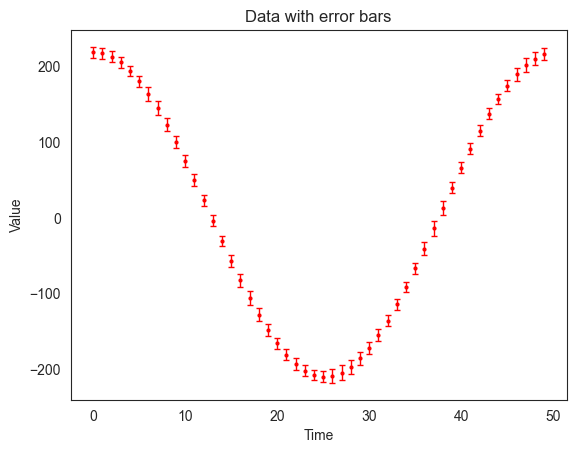

In [57]:
# import numpy as np
# import matplotlib.pyplot as plt

# store_list = np.asarray([y_measure[i*50:i*50+50] for i in range(int(len(y_measure)/50))])
# print('Shape ', store_list.shape)

# def pointRange(pointList):
#     mean_point = np.mean(pointList)
#     #point_range = [mean_point - np.min(pointList), np.max(pointList) - mean_point]
#     point_range = 2*np.std(pointList)
#     return mean_point, point_range

# err_matrix = []
# y_locat = []

# for i in range(store_list.shape[1]):
#     mean_i, range_i = pointRange(store_list[:, i])
#     err_matrix.append(range_i)
#     y_locat.append(mean_i)

# err_matrix = np.asarray(err_matrix)    
# y_locat = np.asarray(y_locat)
# time_period = np.arange(0, 50)

# plt.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, markersize=2, errorevery=1)

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Data with error bars')

# plt.show()


Shape  (1000, 50)


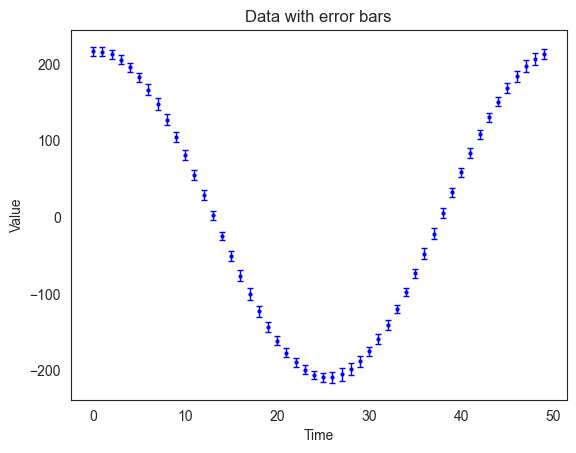

In [58]:
# import numpy as np
# import matplotlib.pyplot as plt

# new_store_list = np.asarray([kf_estimate_measure[i*50:i*50+50] for i in range(int(len(y_measure)/50))])
# print('Shape ', new_store_list.shape)

# def pointRange(pointList):
#     mean_point = np.mean(pointList)
#     #point_range = [mean_point - np.min(pointList), np.max(pointList) - mean_point]
#     point_range = 2*np.std(pointList)
#     return mean_point, point_range

# new_err_matrix = []
# new_y_locat = []

# for i in range(new_store_list.shape[1]):
#     mean_i, range_i = pointRange(new_store_list[:, i])
#     new_err_matrix.append(range_i)
#     new_y_locat.append(mean_i)

# new_err_matrix = np.asarray(new_err_matrix).T    
# new_y_locat = np.asarray(new_y_locat)
# new_time_period = np.arange(0, 50)

# plt.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2, markersize=2, errorevery=1)

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Data with error bars')

# plt.show()


In [59]:

# plt.plot(time_period, z_ref[:50], color='gray')
# plt.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, markersize=2, errorevery=1)
# plt.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2, markersize=2, errorevery=1)

# plt.xlabel('Measure Time (ms)')
# plt.ylabel('Response (mV)')
# #plt.title('Data with error bars')```````

In [60]:
# from scipy import stats

# # Plot the data with error bars
# fig, ax = plt.subplots()
# ax.plot(time_period, z_ref[:50], color='gray')
# ax.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, markersize=2, errorevery=1, label='Data Set 1')
# ax.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2, markersize=2, errorevery=1, label='Data Set 2')

# # Add labels and legend
# ax.set_xlabel('Measurement Time (ms)')
# ax.set_ylabel('Response (mV)')
# #ax.legend()

# # Calculate effect size and perform t-test
# effect_size = np.abs(np.mean(y_locat) - np.mean(new_y_locat)) / np.sqrt((np.var(y_locat) + np.var(new_y_locat)) / 2)
# t_stat, p_val = stats.ttest_ind(y_locat, new_y_locat)

# # Print effect size and p-value
# print('Effect size:', effect_size)
# print('P-value:', p_val)

# # Show the plot
# plt.show()

In [61]:
# np.mean(new_err_matrix)

6.42694157136681

In [62]:
# np.mean(err_matrix)

7.899023426319046

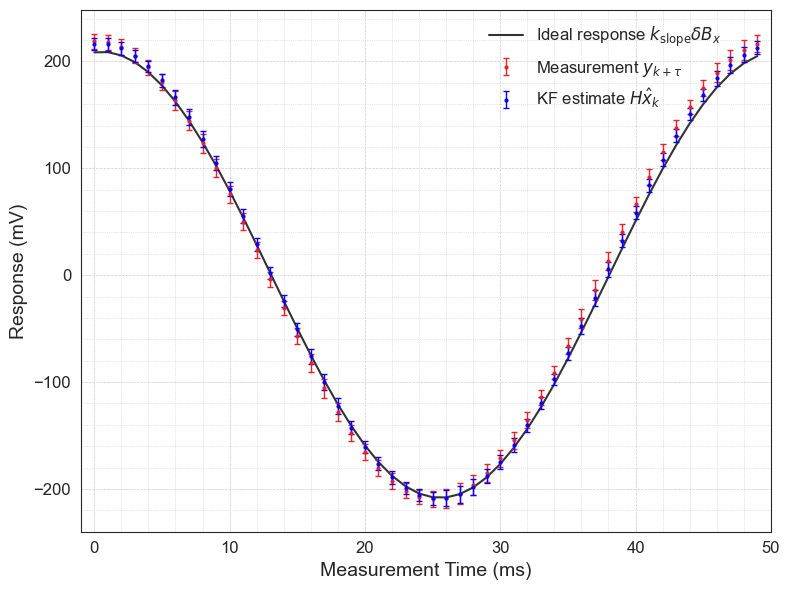

In [76]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set seaborn style
# sns.set_style("white")
# sns.set_palette("bone")


# # Set figure size. figsize=(4,3). gray #C7C9CB  #179DD9
# fig, ax = plt.subplots(figsize=(8,6))

# # Plot the data with error bars
# ax.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#             elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# ax.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
#             ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

# #  , label='KF estimate $H\hat{x}_k$'  , label='Ideal response $k_{slope}\deltaB_x$'   , label='Measurement $y_{k+\tau}$'

# # Add labels and legend
# ax.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
# ax.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# #ax.legend(facecolor='black')

# # Add title to the figure
# #ax.set_title('Measurement Time vs Response', fontsize=14, fontname='Arial')
# # Set color of outer box to black
# # ax.spines['bottom'].set_color('black')
# # ax.spines['top'].set_color('black')
# # ax.spines['left'].set_color('black')
# # ax.spines['right'].set_color('black')

# # Customize grid appearance
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax.minorticks_on()
# ax.grid(which='minor', linestyle=':', linewidth=0.5)

# ax.tick_params(axis='both', labelsize=12)
# ax.legend(loc='upper right', fontsize=12, frameon=False,bbox_to_anchor=(0.95,1.0))
# ax.set_xlim([-1, 50])


# fig.tight_layout()
# plt.savefig('ErrBars.jpg', dpi=300)

# plt.show()


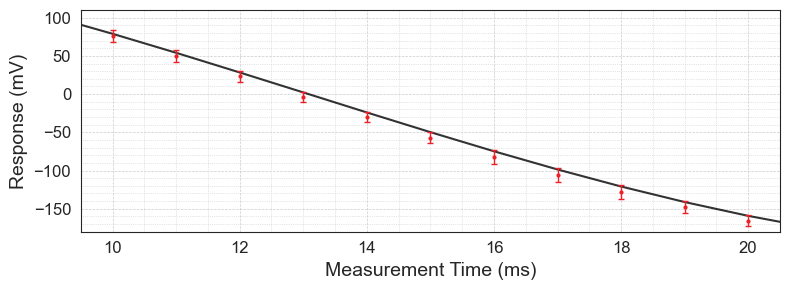

In [77]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set seaborn style
# sns.set_style("white")
# sns.set_palette("bone")


# # Set figure size. figsize=(4,3). gray #C7C9CB
# fig, ax = plt.subplots(figsize=(8,3))

# # Plot the data with error bars
# ax.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#             elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# #ax.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='#179DD9', \
# #            ecolor='#179DD9', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

# #  , label='KF estimate $H\hat{x}_k$'  , label='Ideal response $k_{slope}\deltaB_x$'   , label='Measurement $y_{k+\tau}$'

# # Add labels and legend
# ax.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
# ax.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# #ax.legend(facecolor='black')

# # Add title to the figure
# #ax.set_title('Measurement Time vs Response', fontsize=14, fontname='Arial')
# # Set color of outer box to black
# # ax.spines['bottom'].set_color('black')
# # ax.spines['top'].set_color('black')
# # ax.spines['left'].set_color('black')
# # ax.spines['right'].set_color('black')

# # Customize grid appearance
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax.minorticks_on()
# ax.grid(which='minor', linestyle=':', linewidth=0.5)

# ax.tick_params(axis='both', labelsize=12)
# #ax.legend(loc='upper right', fontsize=12, frameon=False,bbox_to_anchor=(0.95,1.0))
# ax.set_xlim([9.5, 20.5])
# ax.set_ylim([-180, 110])

# fig.tight_layout()
# plt.savefig('ErrBar_red.jpg', dpi=300)

# plt.show()


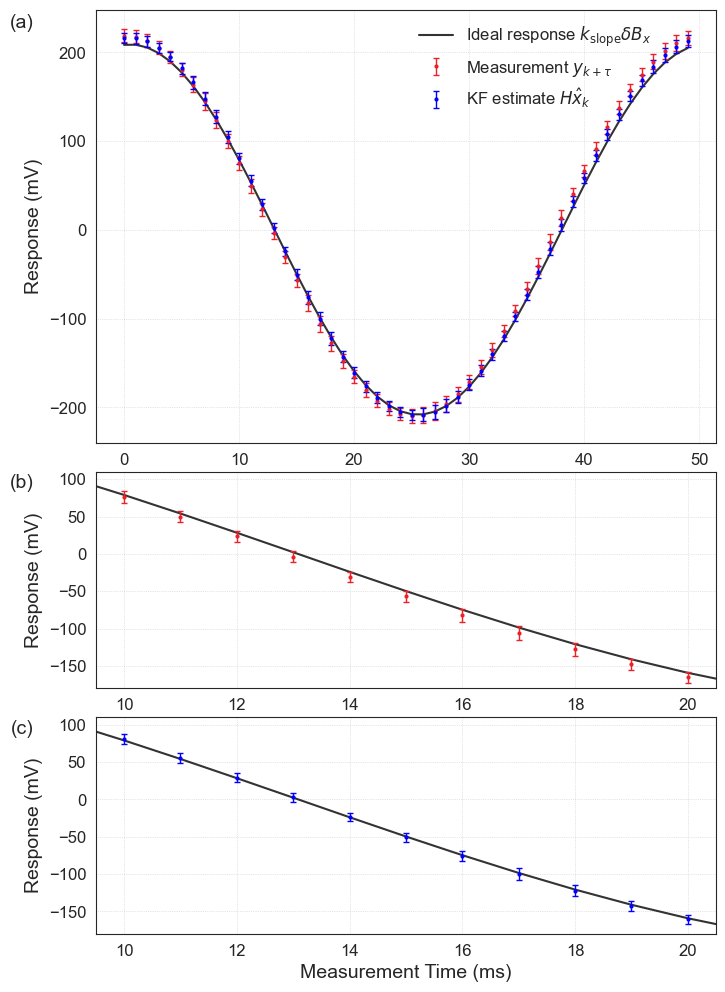

In [101]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set seaborn style
# sns.set_style("white")
# sns.set_palette("bone")

# # # Generate some sample data
# # time_period = np.linspace(0, 10, 100)
# # z_ref = np.sin(time_period)
# # y_locat = np.cos(time_period)
# # err_matrix = np.random.randn(len(time_period)) * 0.1
# # new_time_period = np.linspace(5, 15, 50)
# # new_y_locat = np.tan(new_time_period)
# # new_err_matrix = np.random.randn(len(new_time_period)) * 0.1

# # Create a figure with three subplots in a vertical layout
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(8, 12), gridspec_kw={'height_ratios': [2, 1, 1]})

# # Plot data on each subplot
# ax1.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax1.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#             elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# ax1.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
#             ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

# ax2.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax2.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#             elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# ax2.set_xlim([9.5, 20.5])
# ax2.set_ylim([-180, 110])

# ax3.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax3.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
#             ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')
# ax3.set_xlim([9.5, 20.5])
# ax3.set_ylim([-180, 110])

# # Add labels and legend to each subplot
# # ax1.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# # ax1.grid(which='both', linestyle=':', linewidth=0.5)
# # ax1.tick_params(axis='both', labelsize=12)
# # ax1.legend(loc='upper right', fontsize=12, frameon=False, bbox_to_anchor=(0.92,1.0))

# # ax2.set_ylabel('Response (mV)', fontsize=14, font
# ax1.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# ax1.grid(which='both', linestyle=':', linewidth=0.5)
# ax1.tick_params(axis='both', labelsize=12)
# ax1.legend(loc='upper right', fontsize=12, frameon=False, bbox_to_anchor=(0.92,1.0))

# ax2.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# ax2.grid(which='both', linestyle=':', linewidth=0.5)
# ax2.tick_params(axis='both', labelsize=12)

# ax3.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
# ax3.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# ax3.grid(which='both', linestyle=':', linewidth=0.5)
# ax3.tick_params(axis='both', labelsize=12)

# #Add text labels to subplots
# ax1.text(-0.1, 0.99, '(a)', transform=ax1.transAxes,
# fontsize=14, va='top', ha='right',fontname='Arial')
# ax2.text(-0.1, 0.99, '(b)', transform=ax2.transAxes,
# fontsize=14, va='top', ha='right',fontname='Arial')
# ax3.text(-0.1, 0.99, '(c)', transform=ax3.transAxes,
# fontsize=14, va='top', ha='right',fontname='Arial')

# #Adjust spacing between subplots
# fig.subplots_adjust(hspace=0.1)

# #Save the figure
# plt.savefig('Errbar.png', dpi=300,bbox_inches='tight')

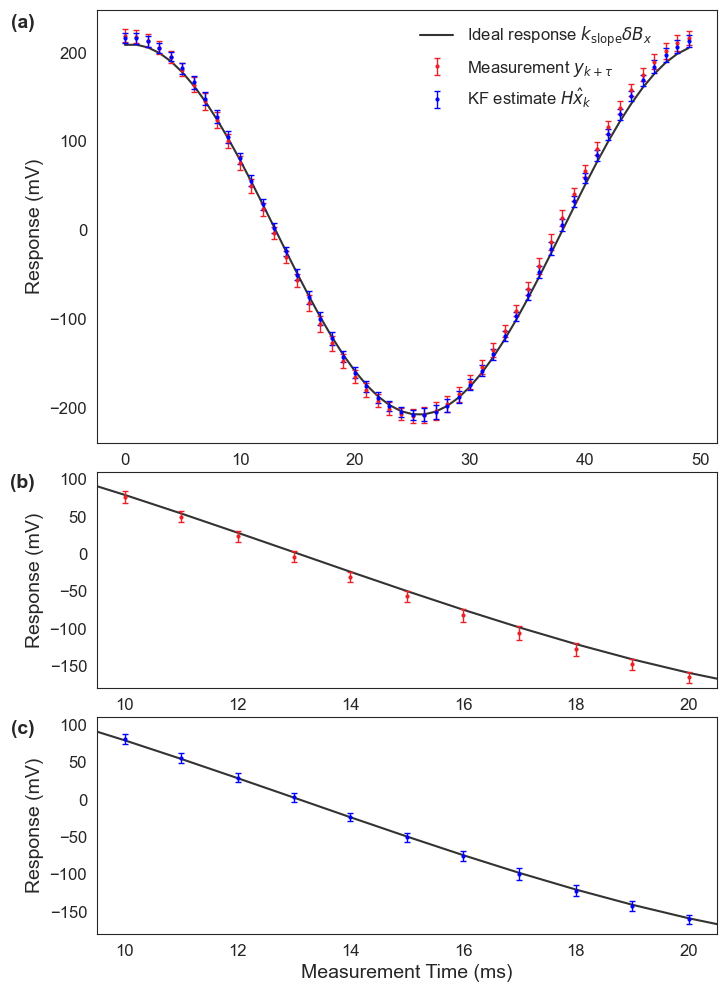

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("white")
sns.set_palette("bone")

# Generate some sample data
# time_period = np.linspace(0, 10, 100)
# z_ref = np.sin(time_period)
# y_locat = np.cos(time_period)
# err_matrix = np.random.randn(len(time_period)) * 0.1
# new_time_period = np.linspace(5, 15, 50)
# new_y_locat = np.tan(new_time_period)
# new_err_matrix = np.random.randn(len(new_time_period)) * 0.1

# Create a figure with three subplots in a vertical layout
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(8, 12), gridspec_kw={'height_ratios': [2, 1, 1]})

# Plot data on each subplot
ax1.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
ax1.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
            elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
ax1.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
            ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

ax2.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
ax2.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
            elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
ax2.set_xlim([9.5, 20.5])
ax2.set_ylim([-180, 110])

ax3.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
ax3.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
            ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')
ax3.set_xlim([9.5, 20.5])
ax3.set_ylim([-180, 110])

# Add labels and legend
ax1.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
ax1.grid(which='minor', linestyle=':', linewidth=0.5)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend
#Add labels and legend to ax2 and ax3
ax2.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
ax2.grid(which='minor', linestyle=':', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
ax3.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
ax3.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
ax3.grid(which='minor', linestyle=':', linewidth=0.5)
ax3.tick_params(axis='both', labelsize=12)

#Add legend to ax1
ax1.legend(loc='upper right', fontsize=12, frameon=False,bbox_to_anchor=(0.92,1.0))

#Add title to the figure
#fig.suptitle('Response vs Measurement Time', fontsize=16, fontname='Arial')  fontweight='bold'


ax1.text(-0.1, 0.99, '(a)', transform=ax1.transAxes,
         fontsize=14, va='top', ha='right',fontname='Arial',fontweight='bold')
ax2.text(-0.1, 0.99, '(b)', transform=ax2.transAxes,
         fontsize=14, va='top', ha='right',fontname='Arial',fontweight='bold')
ax3.text(-0.1, 0.99, '(c)', transform=ax3.transAxes,
         fontsize=14, va='top', ha='right',fontname='Arial',fontweight='bold')


#Adjust spacing between subplots
fig.subplots_adjust(hspace=0.1)

#Save the figure
plt.savefig('response_vs_time.png', dpi=300)

#Show the plot
plt.show()


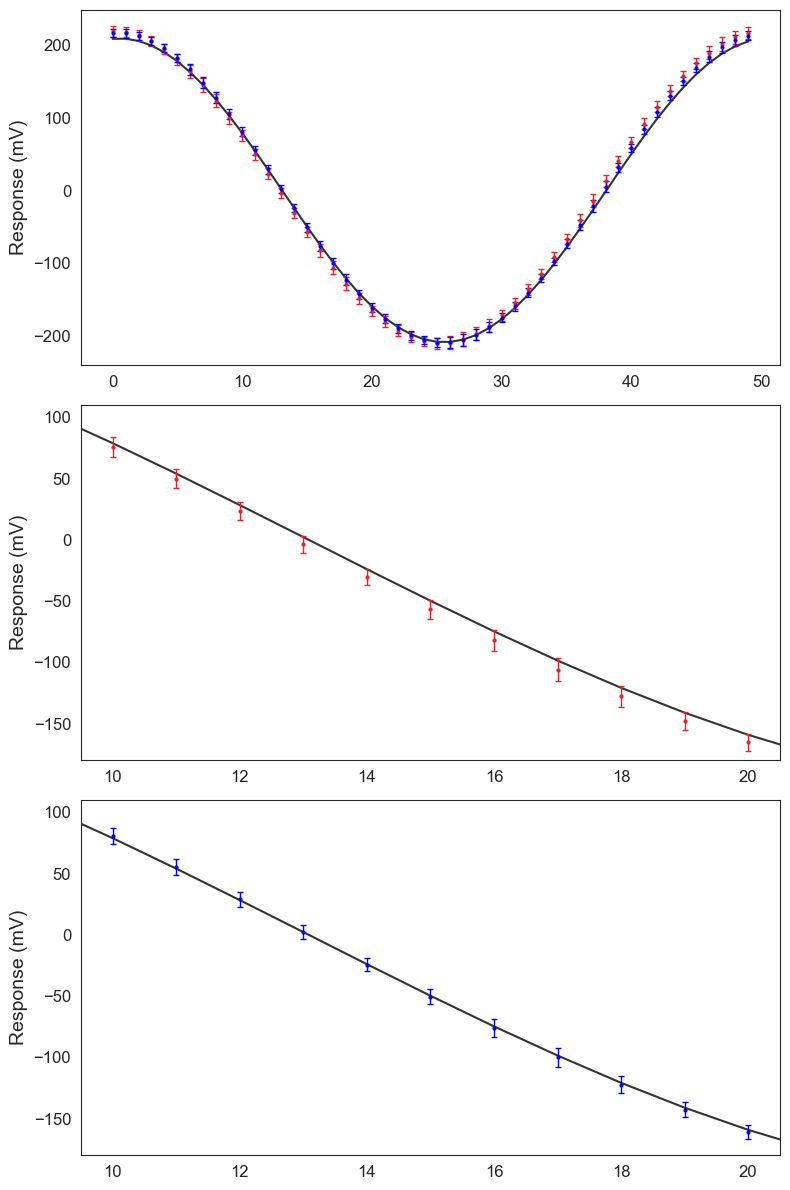

In [84]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set seaborn style
# sns.set_style("white")
# sns.set_palette("bone")


# # Create a figure with three subplots in a vertical layout
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(8,12))



# # Plot the data with error bars
# ax1.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax1.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#             elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# ax1.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
#             ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

# #  , label='KF estimate $H\hat{x}_k$'  , label='Ideal response $k_{slope}\deltaB_x$'   , label='Measurement $y_{k+\tau}$'

# # Add labels and legend
# # ax.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
# ax1.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# ax1.grid(which='minor', linestyle=':', linewidth=0.5)
# ax1.tick_params(axis='both', labelsize=12)
# #ax.legend(loc='upper right', fontsize=12, frameon=False,bbox_to_anchor=(0.95,1.0))





# ax2.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# ax2.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#             elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# #ax.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='#179DD9', \
# #            ecolor='#179DD9', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

# #  , label='KF estimate $H\hat{x}_k$'  , label='Ideal response $k_{slope}\deltaB_x$'   , label='Measurement $y_{k+\tau}$'

# # Add labels and legend
# #ax.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
# ax2.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# ax2.set_xlim([9.5, 20.5])
# ax2.set_ylim([-180, 110])
# ax2.grid(which='minor', linestyle=':', linewidth=0.5)
# ax2.tick_params(axis='both', labelsize=12)


# ax3.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
# #ax.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
# #            elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
# ax3.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
#             ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

# #  , label='KF estimate $H\hat{x}_k$'  , label='Ideal response $k_{slope}\deltaB_x$'   , label='Measurement $y_{k+\tau}$'

# # Add labels and legend
# #ax.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
# ax3.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
# ax3.set_xlim([9.5, 20.5])
# ax3.set_ylim([-180, 110])
# ax3.grid(which='minor', linestyle=':', linewidth=0.5)
# ax3.tick_params(axis='both', labelsize=12)


# fig.tight_layout()
# #plt.savefig('ErrBar_blue.jpg', dpi=300)

# plt.show()


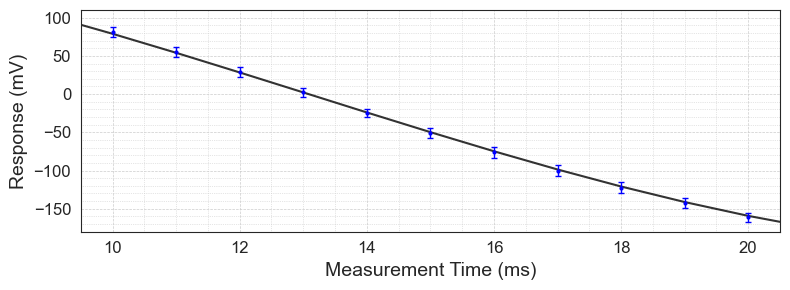

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("white")
sns.set_palette("bone")


# Set figure size. figsize=(4,3). gray #C7C9CB
fig, ax = plt.subplots(figsize=(8,3))

# Plot the data with error bars
ax.plot(time_period, z_ref[:50], color='black',label=r'Ideal response $k_{\mathrm{slope}}\delta B_x$',alpha=0.8)
#ax.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o',color='#EC2027', ecolor='#EC2027', \
#            elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'Measurement $y_{k+\tau}$')
ax.errorbar(new_time_period, new_y_locat, yerr=new_err_matrix,fmt='o', color='blue', \
            ecolor='blue', elinewidth=1, capsize=2, markersize=2, errorevery=1, label=r'KF estimate $H\hat{x}_k$')

#  , label='KF estimate $H\hat{x}_k$'  , label='Ideal response $k_{slope}\deltaB_x$'   , label='Measurement $y_{k+\tau}$'

# Add labels and legend
ax.set_xlabel('Measurement Time (ms)', fontsize=14, fontname='Arial')
ax.set_ylabel('Response (mV)', fontsize=14, fontname='Arial')
#ax.legend(facecolor='black')

# Add title to the figure
#ax.set_title('Measurement Time vs Response', fontsize=14, fontname='Arial')
# Set color of outer box to black
# ax.spines['bottom'].set_color('black')
# ax.spines['top'].set_color('black')
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_color('black')

# Customize grid appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5)

ax.tick_params(axis='both', labelsize=12)
#ax.legend(loc='upper right', fontsize=12, frameon=False,bbox_to_anchor=(0.95,1.0))
ax.set_xlim([9.5, 20.5])
ax.set_ylim([-180, 110])

fig.tight_layout()
plt.savefig('ErrBar_blue.jpg', dpi=300)

plt.show()


In [65]:
# ## 进一步数据分析
# import numpy as np
# store_list = np.asarray([kf_estimate_measure[i*50:i*50+50] for i in range(int(len(kf_estimate_measure)/50))])
# print('Shape ', store_list.shape)

# def pointRange(pointList):
#     mean_point = np.mean(pointList)
#     point_range = [mean_point - np.min(pointList), np.max(pointList) - mean_point]
#     return mean_point, point_range

# err_matrix = []
# y_locat = []

# for i in range(store_list.shape[1]):
#     mean_i, range_i = pointRange(store_list[:, i])
#     err_matrix.append(range_i)
#     y_locat.append(mean_i)

# err_matrix = np.asarray(err_matrix).T    
# y_locat = np.asarray(y_locat)
# time_period = np.arange(0, 50)
# #plt.plot(time_period, y_locat)

# plt.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='b', ecolor='b', elinewidth=2, capsize=4,errorevery=2)


In [66]:
# # Plot the KF estimate on the input curve
# plt.figure()
# plt.plot(time_range, b_input, linestyle='-', linewidth=2, label='Reference', color='blue')
# plt.plot(time_range, kf_estimate_input, 'o', markersize=5, linestyle='', label='Prediction', alpha=0.5, color='red')
# plt.title('KF Estimate on the Input Curve')
# plt.xlabel('Time (s)')
# plt.ylabel('Magnetic Field (pT)')
# plt.legend(loc='upper left')
# plt.show()

# # # Plot the yMeasure future on the zRef curve
# # plt.figure()
# # plt.plot(time_range, z_ref, linestyle='-', linewidth=2, label='Reference', color='blue')
# # plt.plot(time_range[::2], y_measure[::2], 'o', markersize=5, linestyle='', label='Prediction', alpha=0.5, color='red')
# # plt.title('yMeasure Future on the zRef Curve')
# # plt.xlabel('Time (s)')
# # plt.ylabel('Magnetic Field (pT)')
# # plt.legend(loc='upper left')
# # plt.show()

# # Plot the yMeasure on the KF estimate
# plt.figure()
# plt.plot(time_range, kf_estimate_measure, linestyle='-', linewidth=2, label='KF Estimate', color='red')
# plt.plot(time_range, y_measure, 'o', markersize=5, linestyle='', label='Measurement', alpha=0.5, color='blue')
# plt.title('yMeasure on KF Estimate')
# plt.xlabel('Time (s)')
# plt.ylabel('Magnetic Field (pT)')
# plt.legend(loc='upper left')
# plt.show()

# # Plot the KF on the zRef curve
# plt.figure()
# plt.plot(time_range, z_ref, linestyle='-', linewidth=2, label='Reference', color='blue')
# plt.plot(time_range,kf_estimate_measure, linestyle='-', linewidth=2, label='KF Estimate', color='red')
# plt.title('KF Estimate on the zRef Curve')
# plt.xlabel('Time (s)')
# plt.ylabel('Magnetic Field (pT)')
# plt.legend(loc='upper left')
# plt.show()


In [67]:
import numpy as np

# Define the reference curve, measured curve, and Kalman filter estimate curve
# z_ref = np.array([1, 2, 3, 4, 5])
# y_measure_current = np.array([0.8, 1.9, 2.8, 4.1, 4.9])
# kf_estimate_measure = np.array([1.2, 2.0, 2.9, 4.2, 5.1])

# Compute the signal power
signal_power = np.mean(np.square(z_ref))

# Compute the noise power for the measured curve
#noise_measure_power = np.mean(np.square(z_ref - y_measure_current))
noise_measure_power = np.mean(np.square(z_ref - y_measure)) # 延时处理

# Compute the noise power for the Kalman filter estimate curve
noise_kf_power = np.mean(np.square(z_ref - kf_estimate_measure))

# Compute the SNR for the measured curve and Kalman filter estimate curve
snr_measure = 10 * np.log10(signal_power / noise_measure_power)
snr_kf = 10 * np.log10(signal_power / noise_kf_power)

# Print the SNR values
print("SNR for measured curve: {:.2f} dB".format(snr_measure))
print("SNR for Kalman filter estimate curve: {:.2f} dB".format(snr_kf))


SNR for measured curve: 23.22 dB
SNR for Kalman filter estimate curve: 27.68 dB


Text(0.5, 1.0, 'KF Error on y_measure Current')

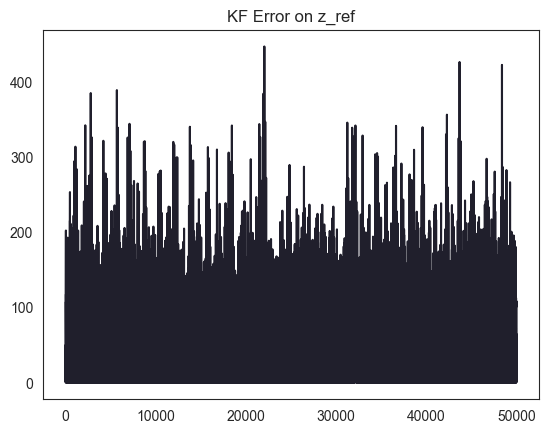

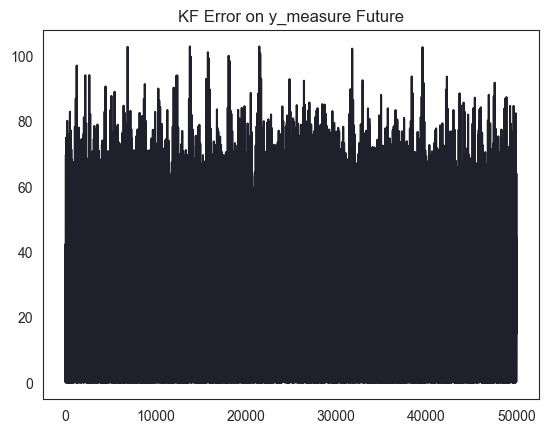

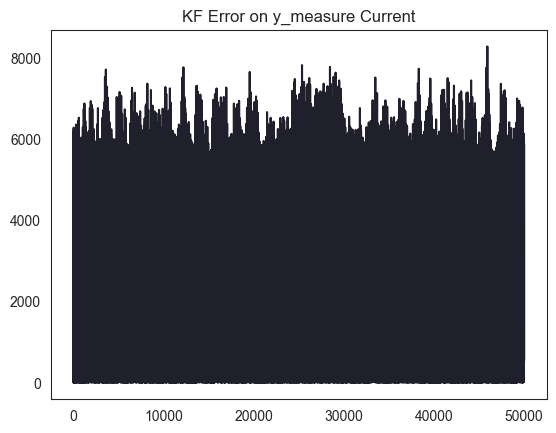

In [68]:
# Error plots
bin_err = kf_estimate_measure - z_ref
measure_err_future = kf_estimate_measure - y_measure
measure_err_current = kf_estimate_measure - y_measure_current

plt.figure()
plt.plot(bin_err**2)
plt.title('KF Error on z_ref')

plt.figure()
plt.plot(measure_err_future**2)
plt.title('KF Error on y_measure Future')

plt.figure()
plt.plot(measure_err_current**2)
plt.title('KF Error on y_measure Current')


In [69]:
np.savetxt('yMeasure.txt', y_measure)
np.savetxt('KF_y.txt', kf_estimate_measure)

In [70]:
from scipy.spatial.distance import euclidean

KF_distance = euclidean(kf_estimate_measure, z_ref)/len(time_range)
Measure_distance = euclidean(y_measure, z_ref)/len(time_range)

print("Euclidean distance between the KF curves:", KF_distance)
print("Euclidean distance between the Measure curves:", Measure_distance)

Euclidean distance between the KF curves: 0.027254759852511763
Euclidean distance between the Measure curves: 0.045544549915443565
